# Physics 494/594
## Gradient Descent Exercise

In [22]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s.set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Last Time

### [Notebook Link: 12_Adaptive_Gradient_Descent.ipynb](./12_Adaptive_Gradient_Descent.ipynb)

- Derived a general framework (gradient descent) for optimizing functions of many parameters and saw various improvements.

## Today

- Explore this method to optimize a tricky function

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

# --------------------------------------------------------------------------------------------
def plot_function(grid_1d, func, contours=50, log_contours=False, exact=[0,0]):
    '''Make a contour plot over the region described by grid_1d for function func.'''
    
    # make the 2D grid
    X,Y = np.meshgrid(grid_1d, grid_1d, indexing='xy')
    Z = np.zeros_like(X)
    
    # numpy bonus exercise: can you think of a way to vectorize the following for-loop?
    for i in range(len(X)):
        for j in range(len(X.T)):
            Z[i, j] = func(np.array((X[i, j], Y[i, j])))  # compute function values
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1)
    
    if not log_contours:
        ax.contour(X, Y, Z, contours, cmap='Spectral_r')
    else:
        ax.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap='Spectral_r')
        
    ax.plot(*exact, '*', color='black')

    ax.set_xlabel(r'$w_0$')
    ax.set_ylabel(r'$w_1$')
    ax.set_aspect('equal')
    
    ax3d = fig.add_subplot(1, 2, 2, projection='3d')
    
    if log_contours:
        Z = np.log(Z)
        label = r'$\ln f(\mathbf{w}$'
    else:
        label = r'$f(\mathbf{w})$'
        
    surf = ax3d.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap='Spectral_r', 
                       linewidth=0, antialiased=True, rasterized=True)
    
    ax3d.plot([exact[0]], [exact[0]], [func(np.array(exact))], marker='*', ms=6, linestyle='-', color='k',lw=1, zorder=100)

         
    ax3d.set_xlabel(r'$w_0$',labelpad=8)
    ax3d.set_ylabel(r'$w_1$',labelpad=8)
    ax3d.set_zlabel(label,labelpad=8);
    
    return fig,ax,ax3d

# --------------------------------------------------------------------------------------------
def plot_trajectory(fig,ax,ax3d,w_traj,func,log_contours=False):
    '''Plot the trajectory of a minimization.'''
    
    num_iter = w_traj.shape[0]
    f_traj = np.array([func(w_traj[i,:]) for i in range(num_iter)])
    
    ax.plot(w_traj[0,0],w_traj[0,1], 'o', color='k', ms=6)    
    ax.plot(w_traj[:,0],w_traj[:,1], '.', color='k', ms=1)  
    
    if log_contours:
        f_traj = np.log(f_traj)
        
    ax3d.plot([w_traj[0,0]], [w_traj[0,1]], [f_traj[0]], marker='o', ms=6, linestyle='-', color='k',lw=1, zorder=100)
    ax3d.plot(w_traj[:,0], w_traj[:,1], f_traj, marker='.', ms=1, linestyle='-', color='k',lw=1, zorder=100)
    
    ax.set_title(f'$i={i}, w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$f(w) = {func(w):.6f}$', fontsize=14);
    
    return fig,ax,ax3d

<div class="span alert alert-success">
<h2>Programming Exercise: Beale's Function </h2>

1. Define a new [Beale's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), a convex function often used to test optimization problems of the form:
    
\begin{equation}
    f(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
\end{equation}
    
It has a minimum at $(x,y) = (3,0.5)$.
</div>

In [24]:
import jax.numpy as jnp 
from jax import grad

In [44]:
def beales(X):
    x = X[0]
    y = X[1]
    beale_func = (1.5-x+x*y)**2 + (2.25-x+x*(y**2))**2 + (2.625-x+x*(y**3))**2
    return beale_func

db_dx = grad(beales,argnums=0)

<div class="span alert alert-success">
    2. Make a plot.  Add <code>log_contours=True</code> to see things better.
</div>

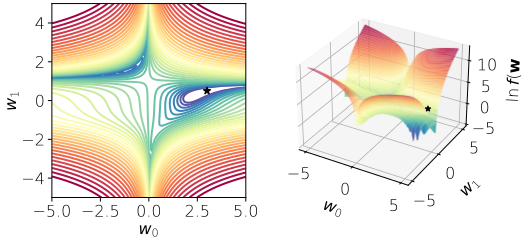

In [63]:
fig, ax, ax3d = plot_function(np.linspace(-5, 5, 100), beales, exact=[3,0.5],log_contours=True)

<div class="span alert alert-success">
    3. Try to find the minimum with NAG.
</div>

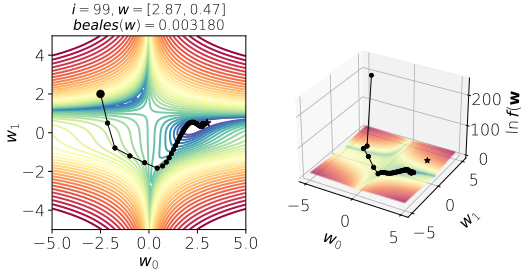

In [79]:
from IPython import display
fig, ax, ax3d = plot_function(np.linspace(-5, 5, 100), beales, exact=[3,0.5],log_contours=True)
# hyperparameters
η = 0.0015
γ = 0.9
num_iter = 100

# I choose a specific starting point (-2.5,2)
w = np.array([-2.5,2])

ax.plot(*w, marker='.', color='k', ms=15)  

w_traj = np.zeros([num_iter,2])
w_traj[0,:] = w

v = np.zeros(2)

for i in range(1,num_iter):
    
    # keep a copy for plotting
    w_old = np.copy(w)
    
    # perform the NAG update
    v = γ*v + η*db_dx(w-γ*v)
    w -= v
    
    # plot
    ax.plot([w_old[0], w[0]], [w_old[1], w[1]], marker='.', linestyle='-', color='k',lw=1) 
    ax3d.plot([w_old[0], w[0]], [w_old[1], w[1]], [beales(w_old),beales(w)], marker='.', linestyle='-', color='k',lw=1, zorder=100)

    ax.set_title(f'$i={i}, w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$beales(w) = {beales(w):.6f}$', fontsize=14);
    display.display(fig)
    display.clear_output(wait=True)

A learning rate somewhere around 1.5e-3 does not blow-up and obtains decent accuracy in only 100 iterations. 

<div class="span alert alert-warning">
    If your code fails, try playing with the learning rate $\eta$.
</div>

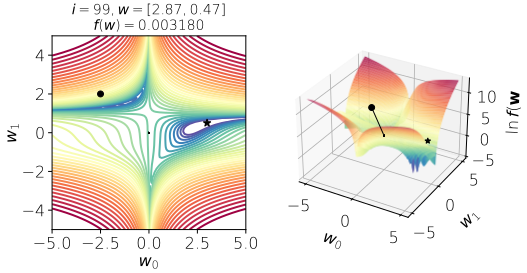

In [80]:
fig, ax, ax3d = plot_function(np.linspace(-5, 5, 100), beales, log_contours=True, exact=[3,0.5])
fig, ax, ax3d  = plot_trajectory(fig,ax,ax3d,w_traj,beales,log_contours=True)

<div class="span alert alert-success">
    4. Repeat with ADAM.  Experiment with different learning rates.
</div>

In [87]:
# hyperparameters

β1 = 0.9
β2 = 0.999
ϵ = 1.0E-8
η = 5.0E-1
γ = 0.9
num_iter = 10**3

# if you want you can play with some different initial points
#w = np.random.uniform(low=-3,high=3,size=2)

w = np.array([-2.5,2])

w_traj = np.zeros([num_iter,2])
w_traj[0,:] = w

m = np.zeros(2)
v = np.zeros(2)

for i in range(1,num_iter):
        
    g = np.array(db_dx(w))
    m = β1*m + (1-β1)*g
    v = β2*v + (1-β2)*g*g
    
    m̂ = m/(1-β1**i)
    v̂ = v/(1-β2**i)

    w = w - η*np.divide(m̂,np.sqrt(v̂) + ϵ)
    w_traj[i,:] = w

In [85]:
def plot_trajectory(fig,ax,ax3d,w_traj,func,log_contours=False):
    '''Plot the trajectory of a minimization.'''
    
    num_iter = w_traj.shape[0]
    f_traj = np.array([func(w_traj[i,:]) for i in range(num_iter)])
    
    ax.plot(w_traj[0,0],w_traj[0,1], 'o', color='k', ms=6)    
    ax.plot(w_traj[:,0],w_traj[:,1], '.', color='k', ms=1)  
    
    if log_contours:
        f_traj = np.log(f_traj)
        
    ax3d.plot([w_traj[0,0]], [w_traj[0,1]], [f_traj[0]], marker='o', ms=6, linestyle='-', color='k',lw=1, zorder=100)
    ax3d.plot(w_traj[:,0], w_traj[:,1], f_traj, marker='.', ms=1, linestyle='-', color='k',lw=1, zorder=100)
    
    ax.set_title(f'$i={i}, w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$f(w) = {func(w):.6f}$', fontsize=14);
    
    return fig,ax,ax3d

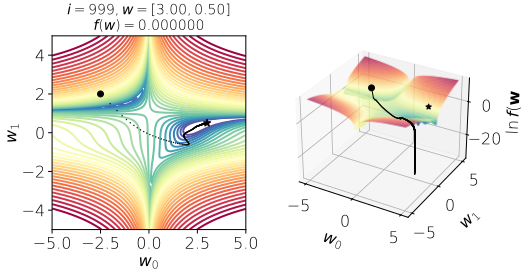

In [88]:
fig, ax, ax3d = plot_function(np.linspace(-5, 5, 100), beales, log_contours=True, exact=[3,0.5])
fig, ax, ax3d  = plot_trajectory(fig,ax,ax3d,w_traj,beales,log_contours=True)

Was able to very accurately find the minimum using learning rate 0.5.